## Functional programming and `toolz` use cases


These examples are adapted from Juan Nunez-Iglesias' [Linux conference Australia talk in 2016](https://www.youtube.com/watch?v=INAvD4Kmdbc). Refer to [his github repo](https://github.com/jni/functional-programming-in-python) for additional examples.


In [1]:
from itertools import groupby

from toolz import curry
from toolz.functoolz import compose, pipe
from toolz.curried import map as mapc
from toolz.curried import filter as filterc

### Plot the distribution of codons in a given fasta file

#### dataset

A random selection of 100 protein coding transcripts from human genome

`data/transcripts.fa`

In [2]:
def read_fasta(fa):
    '''
    https://www.biostars.org/p/710/
    '''
    with open(fa,'r') as fh:
        faiter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))
        for grp in faiter:
#             header = grp.__next__()[1:].strip()
#             seq = "".join(s.strip() for s in faiter.__next__())
            seq = pipe(faiter.__next__(), mapc(lambda s: s.strip()), curry(''.join))
            yield seq

In [3]:
import pandas as pd
import seaborn as sns

from collections import Counter
import matplotlib.pyplot as plt

# partition: partition sequence into tuples of length n partition(n, sequence)
# partition(2, [1,2,3,4])
#     [(1,2),(3, 4)]
#
# concat: Concatenate iterables
#     itertools.chain.from_iterable(seqs)
from toolz.itertoolz import partition, concat
from toolz.functoolz import pipe

In [4]:
triplet_fn = mapc(curry(partition)(3))
triplet_counts = pipe('data/transcripts.fa',read_fasta, triplet_fn, concat, mapc(''.join), Counter)

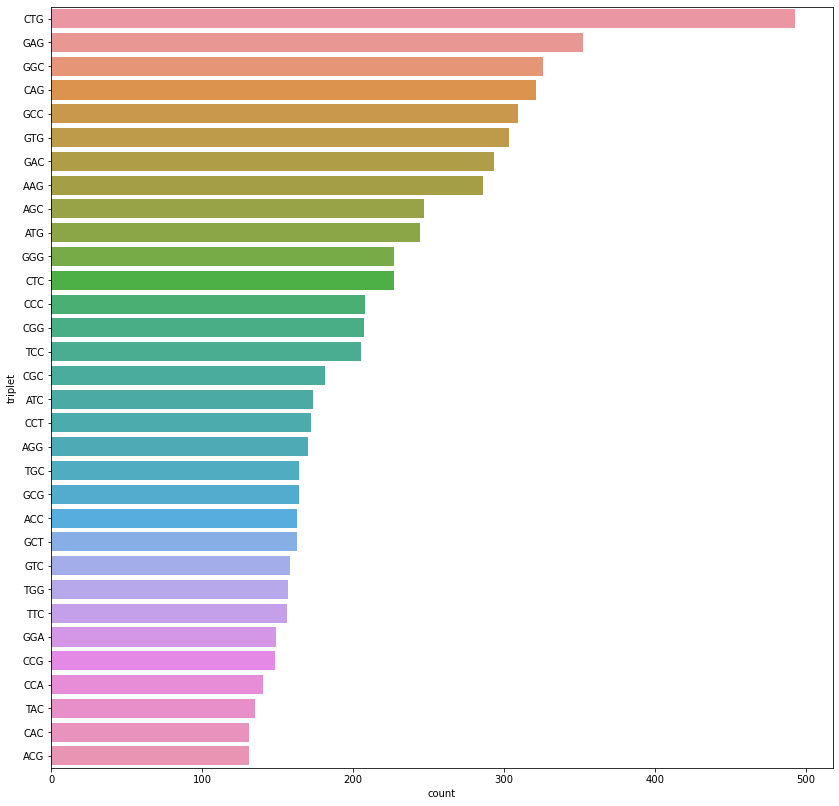

In [5]:
plt.figure(figsize=(14, 14))
triplet_df = pd.DataFrame( triplet_counts.most_common(32), columns = ['triplet', 'count'] )
triplet_plot = sns.barplot(x = 'count', y = 'triplet', data = triplet_df)


### Streaming and filtering read count data

#### Airway dataset

Himes BE, Jiang X, Wagner P, Hu R, Wang Q, Klanderman B, Whitaker RM, Duan Q, Lasky-Su J, Nikolos C, Jester W, Johnson M, Panettieri R Jr, Tantisira KG, Weiss ST, Lu Q. “RNA-Seq Transcriptome Profiling Identifies CRISPLD2 as a Glucocorticoid Responsive Gene that Modulates Cytokine Function in Airway Smooth Muscle Cells.” [PLoS One. 2014 Jun 13;9(6):e99625](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0099625)

Airway smooth muscle cells were treated with dexamethasone, a synthetic steroid with anti-inflammatory effects and expression levels were measured using RNA-seq.

`data/airway.csv`

In [6]:
import pandas as pd

In [7]:
airway = pd.read_csv('data/airway.csv',sep="\t", header=None, index_col = 0)

In [8]:
airway

1    2    3    4     5     6    7    8
0                                                        
ENSG00000000003  679  448  873  408  1138  1047  770  572
ENSG00000000005    0    0    0    0     0     0    0    0
ENSG00000000419  467  515  621  365   587   799  417  508
ENSG00000000457  260  211  263  164   245   331  233  229
ENSG00000000460   60   55   40   35    78    63   76   60
...              ...  ...  ...  ...   ...   ...  ...  ...
LRG_94             0    0    0    0     0     0    0    0
LRG_96             0    0    0    0     0     0    0    0
LRG_97             0    0    0    0     0     0    0    0
LRG_98             0    0    0    0     0     0    0    0
LRG_99             0    0    0    0     0     0    0    0

[64102 rows x 8 columns]

### Find all genes with mean read count $\ge$  50

#### Using `pandas`

In [9]:
airway_mean = airway.mean(axis=1)
airway_mean[airway_mean>=50]

0
ENSG00000000003     741.875
ENSG00000000419     534.875
ENSG00000000457     242.000
ENSG00000000460      58.375
ENSG00000000971    6034.750
                     ...   
ENSG00000273179     174.875
ENSG00000273230     119.500
ENSG00000273270     137.375
ENSG00000273290     168.500
ENSG00000273344      65.500
Length: 12671, dtype: float64

#### Using `for` loop and `map`

In [10]:
from statistics import mean

In [11]:
airway_genes = []
with open('data/airway.csv','r') as fh:
    for f in fh:
        seq_data = f.strip().split('\t')
        count_data = map(int, seq_data[1:])
        count_mean = mean(count_data)
        if count_mean > 50.0:
            airway_genes.append((seq_data[0],count_mean))

In [12]:
print('Genes after filtering: ',len(airway_genes))
print('First 3 from list: ', airway_genes[:3])

Genes after filtering:  12666
First 3 from list:  [('ENSG00000000003', 741.875), ('ENSG00000000419', 534.875), ('ENSG00000000457', 242)]


#### Rewriting using `pipe` and curried versions of `reduce` and `filter`

Data flow: `open` $\rightarrow$ `split` $\rightarrow$ `map` $\rightarrow$ `reduce` $\rightarrow$ `filter`

In [13]:
def read_data(fin):
    with open(fin,'r') as fh:
        for l in fh:
            yield l.strip().split('\t')

def map_int_mean(raw_data):
    count_mean = pipe(raw_data[1:], mapc(int), mean)
    return (raw_data[0],count_mean)

def filter_mean(gene_tuple):
    return gene_tuple[1] >= 50.00

In [14]:
airway_genes_50 = pipe('data/airway.csv',
                       read_data,
                       mapc(map_int_mean), 
                       filterc(filter_mean))

In [15]:
len(list(airway_genes_50))

12671

#### Rewriting `map_int_mean` using `compose`

In [16]:
def map_int_mean_compose(raw_data):
    mean_from_str = compose(mean, mapc(int))
    return (raw_data[0], mean_from_str(raw_data[1:]))

In [17]:
airway_genes_50 = pipe('data/airway.csv', 
                       read_data,
                       mapc(map_int_mean_compose),
                       filterc(filter_mean))

In [18]:
len(list(airway_genes_50))

12671

#### Rewriting `filter_mean` as a curried version

Adding an additional input `thresh` for  `filter_mean` 

In [19]:
@curry # <--- using curry function as a decorator
def filter_mean_thresh(gene_tuple,thresh=0.0):
    return gene_tuple[1] >= thresh

In [20]:
airway_genes_100 = pipe('data/airway.csv', 
                        read_data, 
                        mapc(map_int_mean_compose),
                        filterc(filter_mean_thresh(thresh=100.0)),
                        list)

In [21]:
len(airway_genes_100)

11244

In [22]:
airway_genes_100[:3]

[('ENSG00000000003', 741.875),
 ('ENSG00000000419', 534.875),
 ('ENSG00000000457', 242)]